# Sixth Classwork/Homework
We have been tasked to use Convolutional Neural Networks to procduce a celebrity recognition model.  
There are a total of two tasks:
1. Split the dataset in train test and test set.
2. Implement a Convolutional Neural Network (CNN), that make a classification of the celebrity. Therefore, you need to use the train set to do the training operation, and the test setto check if the neural network is able to correctly classify the picture given in input.

The dataset is downloadable from [here](https://drive.google.com/drive/folders/1TmwPJGLYzYuLXhfKoewPJooNVMZunJXq?usp=sharing).

Most of the work's been made by folling [PyTorch's own tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), ChatGPT has been used to better explain most of the stuff left to faith there.

### Setting up the environment

We first import a good bunch of tools:

In [1]:
import os
from typing import Any, Optional, Union
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.calibration import LabelEncoder
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

# fix stupid pytorch error
import collections
collections.Iterable = collections.abc.Iterable


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We load our environment file:

In [37]:
#from dotenv import load_dotenv
#load_dotenv()
#HOMEWORK_DATASET = os.getenv('HOMEWORK_DATASET')
HOMEWORK_DATASET = "/content/drive/MyDrive/Celebrity Faces Dataset"
SELECT_CELEBRITIES = ['Natalie Portman', 'Will Smith']

## Task 1: Train/Test splitting

A commodity class has been implemented accomplish such task, by implementing a custom _Dataset_ which:
1. Taken an input path, it will generate a compatible _Dataset_ object for pythorch's image loader, using folder names as labels and folder content as data.
2. Can split with a given ratio the dataset into two, comfortably producing train and test set.

In [9]:
# Scarlett J has too many pictures, I refuse to delete them so we use sample afterwards:
PICS_PER_VIP = 100
class PandasDataset(Dataset):
    df: pd.DataFrame
    transforms: Optional[torchvision.transforms.Compose]
    rng: np.random.Generator
    def __init__(
            self,
            data_or_path: Union[pd.DataFrame,str],
            transforms: Optional[torchvision.transforms.Compose] = None,
            rng: Optional[np.random.Generator] = None
        ):
        self.transforms = transforms
        self.rng = rng if rng is not None else np.random.default_rng()
        if type(data_or_path) is str:
            self.df = self.__create_dataset__(data_or_path)
        else:
            self.df = data_or_path

    def __create_dataset__(self,path: str):
        images = []
        labels = []
        for label in os.listdir(path):
            for image in os.listdir(os.path.join(path,label)):
                images.append(os.path.join(path,label, image))
                labels.append(label)
        df = pd.DataFrame(
            data={
                'image_path': images,
                'label': labels
            }
        )
        df['encoded_label'] = LabelEncoder().fit_transform(df['label'])
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        _id, image_path, _label, encoded_label = tuple(self.df.loc[index])


        image = Image.open(image_path)
        label = torch.tensor(encoded_label)
        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

    def split(self, ratio: float = .7):
        train = []
        test = []
        for label in self.df['encoded_label'].unique():
            df = self.df[self.df['encoded_label'] == label ].sample(PICS_PER_VIP, random_state = self.rng )
            train_df = df.sample(frac=ratio, random_state = self.rng)
            test_df = df[~df.index.isin(train_df.index)]

            train.append(train_df)
            test.append(test_df)

        train_ds = PandasDataset(pd.concat(train).reset_index(), transforms=self.transforms, rng = self.rng)
        test_ds = PandasDataset(pd.concat(test).reset_index(), transforms=self.transforms, rng = self.rng)

        return train_ds, test_ds
    def full_labels(self):
        return self.df[['label', 'encoded_label']].drop_duplicates().sort_values(by='encoded_label', axis=0).reset_index()
    def labels(self):
        return self.full_labels()['encoded_label'].values
    def label_names(self):
        return self.full_labels()['label'].values
    def select_labels(self, labels: list[str] = None, encoded_labels: list[int] = None):
        if labels is not None:
            df = self.df[self.df['label'].isin(labels)]
        else:
            df = self.df[self.df['encoded_label'].isin(encoded_labels)]
        df['encoded_label'] = LabelEncoder().fit_transform(df['label'])
        return PandasDataset(df, transforms=self.transforms, rng = self.rng)



Thus we can initialize our data as follow:

>⚠️ Notes:  
> The tutorial I followed used CIFAR10 dataset, which pictures are of size 32x32, our sample has heterogeneous picture sizes, so we resize them to 256x256, which is a bigger size than CIFAR10.

In [38]:
# We resize, transform to tensor then normalize our pictures before feeding them to our NN.
transformations = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5)),
])

batch_size = 4

train_set, test_set = (
    PandasDataset(
        HOMEWORK_DATASET,
        transforms=transformations,
        rng=np.random.default_rng(0xdeadbeef)
    )
    .select_labels(SELECT_CELEBRITIES)
    .split()
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True, num_workers=0)

label_names = train_set.label_names()
num_labels = len(label_names)


<ipython-input-9-b54f9e4b0fc1>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_label'] = LabelEncoder().fit_transform(df['label'])


We show some pictures as the tutorial does:

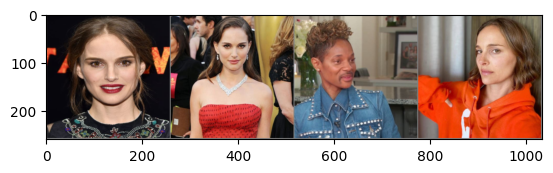

Natalie Portman, Natalie Portman, Will Smith, Natalie Portman


In [40]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(', '.join(f'{label_names[labels[j]]:5s}' for j in range(batch_size)))

# Task 2: CNN Implementation
Follow is a slightly modified version of the tutorial's network, in particular 2 more convolutional layers are present, added with help from ChatGPT, with manually tweaked sizes further on development, a fourth full connected layer has been added by me though.

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 11, padding=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 32, 9, padding=4)
        self.conv3 = nn.Conv2d(32, 64, 7, padding=3)
        self.conv4 = nn.Conv2d(64, 128, 5, padding=2)

        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        #self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(128, len(label_names))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 256 -> 128
        x = self.pool(F.relu(self.conv2(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv3(x)))  # 64 -> 32
        x = self.pool(F.relu(self.conv4(x)))  # 32 -> 16
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()

Follows are the loss function and optimizer:

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Load up cuda device:

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
device

device(type='cuda', index=0)

Follows the actual training loop of our model:

In [44]:
from copy import deepcopy


history = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item() if running_loss == 0.0 else (running_loss + loss.item()) / 2

    history.append({
        'loss': running_loss,
        'state': deepcopy(net.state_dict())
    })

print('Finished Training')


Finished Training


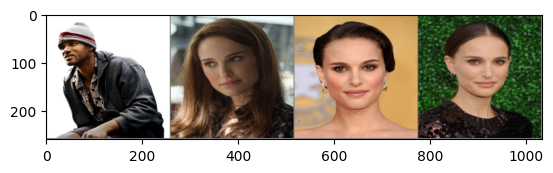

GroundTruth:  Will Smith,Natalie Portman,Natalie Portman,Natalie Portman
Predicted:  Will Smith, Will Smith, Natalie Portman, Natalie Portman


In [47]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ','.join(f'{label_names[labels[j]]:5s}' for j in range(batch_size)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ', '.join(f'{label_names[predicted[j]]:5s}'
                              for j in range(batch_size)))

## Model testing
We run the test data set agains every epoch:

In [48]:
test_loss = []
for epoch in history:  # loop over the dataset multiple times

    net.load_state_dict(epoch['state'])
    running_loss = 0.0
    for i, data in enumerate(test_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)



        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        running_loss = loss.item() if running_loss == 0.0 else (running_loss + loss.item()) / 2

    test_loss.append(running_loss)


And we plot both train and test loss:

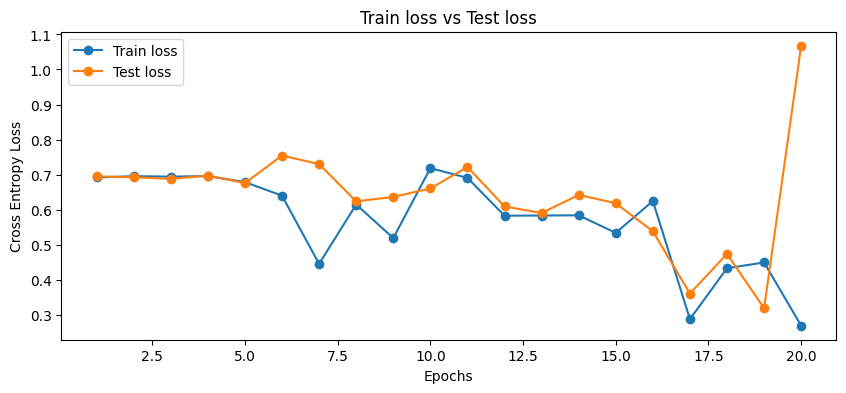

In [49]:
train_loss = [ h['loss'] for h in history ]
plt.figure(figsize=(10,4))
plt.title("Train loss vs Test loss")
plt.plot(1 + np.array(range(len(train_loss))), train_loss, '-o',label="Train loss")
plt.plot(1 + np.array(range(len(test_loss))), test_loss, '-o',label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()


We compute accuracy for each label:

In [57]:
net.load_state_dict(history[-1]['state'])

hits = np.zeros(len(label_names))
miss = np.zeros(len(label_names))

for i, data in enumerate(test_loader, 0):
    inputs, labels = data

    outputs = torch.max(net(inputs.to(device)),1)[1].to('cpu')

    success = (labels == outputs)
    hits[labels] = hits[labels] + np.array(success)
    miss[labels] = miss[labels] + np.invert(np.array(success))



And bar plot each class accuracy and mean:

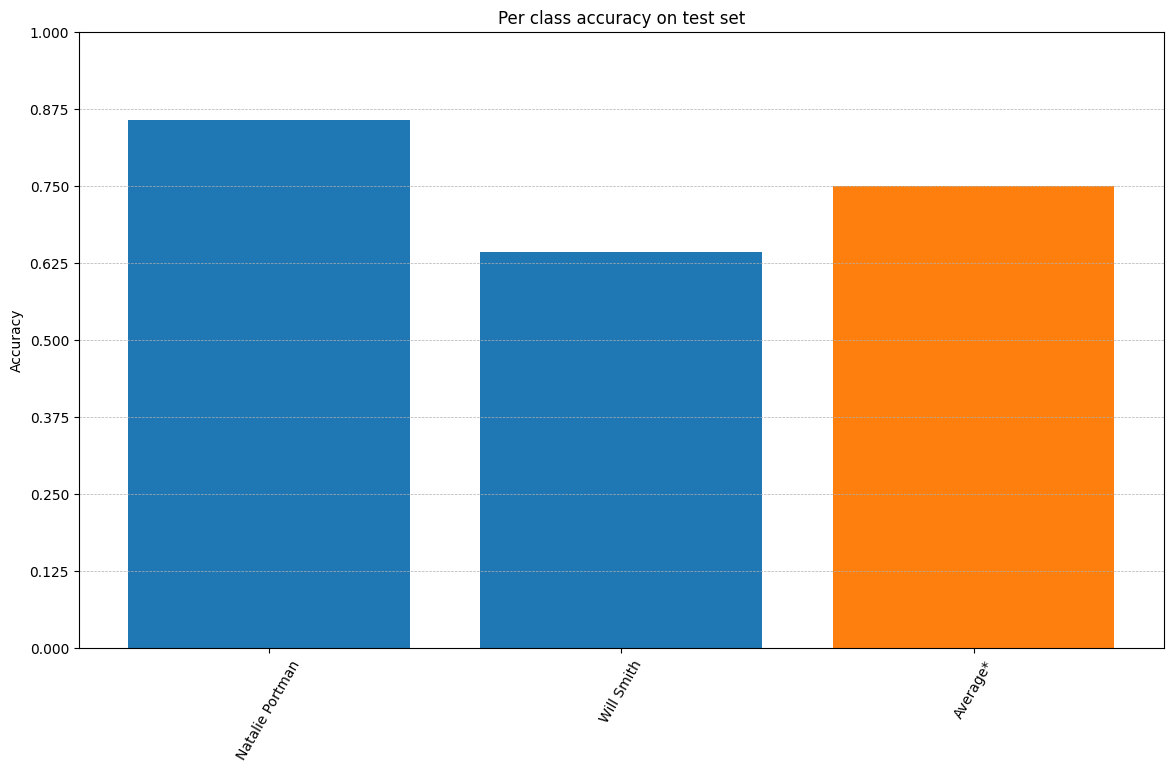

In [58]:
accuracy = hits / ( hits + miss )

plt.figure(figsize=(14,8))
plt.title("Per class accuracy on test set")
plt.bar(label_names, accuracy)
plt.bar(['Average*'], [np.mean(accuracy)])
plt.xticks(rotation=60)
plt.yticks(np.linspace(0,1,9))
plt.ylabel('Accuracy')
plt.ylim(top=1)
plt.grid( axis='y', linestyle='--', linewidth=.5)
plt.show()

The model indeed works very badly.

In [59]:
pd.DataFrame(
    data={
        'label_name': [*label_names, 'Average*'],
        'hits': [*hits, np.mean(hits)],
        'miss': [*miss, np.mean(miss)],
        'accuracy': [*accuracy, np.mean(accuracy)]
    }
)

,label_name,hits,miss,accuracy
0,Natalie Portman,12.0,2.0,0.857143
1,Will Smith,9.0,5.0,0.642857
2,Average*,10.5,3.5,0.750000


Save the model for later use:

In [60]:
torch.save(history[-1]['state'], './model.nogit.zip')